# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [3]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [4]:
# Only for kaggle
# !pip install torch_geometric

In [5]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
!pip install distinctipy -q

In [21]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
# url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"
url_real = "D:\Grad\Planify_Dataset\Graph\graphs\Graphs_real.pkl"
url_boundary = r"D:\Grad\Planify_Dataset\Graph\graphs\boundaries.pkl"
# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [10]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [11]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)

<a id='wrangling'></a>
## Data wrangling


In [12]:
with open(url_real, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)

Graph with 8 nodes and 13 edges


> Considering boundaries

In [13]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


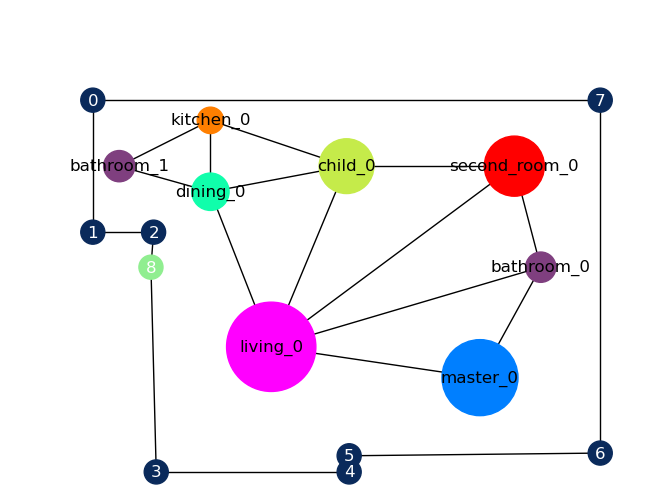

In [14]:
draw_graph_boundary(b)
draw_graph(G)

In [15]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80787/80787 [00:47<00:00, 1706.36it/s]


Data(edge_index=[2, 18], roomType_name=[7], rec_w=[7], rec_h=[7], roomSize=[7], x=[7, 3], edge_attr=[18, 1])

In [16]:
# Converting networkx boundary graphs to pytorchGeo graphs
Boundaries_pyTorch = []
for b in tqdm(boundaries):
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    
    Boundaries_pyTorch.append(b_new)

Boundaries_pyTorch[0]

100%|██████████| 80787/80787 [00:50<00:00, 1596.57it/s]


Data(edge_index=[2, 26], x=[13, 3], edge_attr=[26, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [17]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  9.0000,  77.0000, 210.5000]])


100%|██████████| 80787/80787 [00:06<00:00, 11973.34it/s]

After: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  4.0000,  77.0000, 210.5000]])


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [18]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        mean = torch.mean(x[:, i])
        std  = torch.std(x[:, i])
        
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:21<00:00, 3762.34it/s]


> Normalizing the centroid of the boundaries

In [19]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    x = b.x # The feature matrix
    for i in [1, 2]:
        mean = torch.mean(x[:, i])
        std  = torch.std(x[:, i])
        
        normalized_column = (x[:, i] - mean) / std
        b.x[:, i] = normalized_column

100%|██████████| 80787/80787 [00:13<00:00, 6141.54it/s]


> If we need to creat graphs with padding by the maximum number of nodes.

In [20]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [22]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(device)
        B = self.Boundaries[index].clone().to(device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes).to(device)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        return G, B

In [23]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [24]:
batch_size = 128
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[edge:], Boundaries_pyTorch[:edge])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)
        
        print('Model saved :)')

<a id='archi'></a>
### Architecture

In [26]:
from torch_geometric.nn import GlobalAttention
from torch_geometric.nn.dense import DenseGCNConv

class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=8, dropout=0.2)
        self.graph_conv2 = GATConv(32*8, 64, heads=8, dropout=0.2)
        
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 16, heads=4, dropout=0.2)
        self.boundary_conv2 = GATConv(16*4, 32, heads=4, dropout=0.2)
        
        self.lin1 = torch.nn.Linear(64*8 + 32*4, 32)
        self.lin2 = torch.nn.Linear(32, 2)

    def forward(self, graph, boundary):
        x_graph, edge_index_graph, edge_attr_graph, batch_graph = graph.x, graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, edge_index_boundary, edge_attr_boundary, batch_boundary = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch.to(batch_graph.dtype)
        
        # During testing, as we input only one graph.
        if batch_graph == None:
            batch_graph = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if batch_boundary == None:
            batch_boundary = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        print(f'g.x befor: {x_graph.shape}')
        # Passing the graph throught a message passing to embed its features
        x_graph = F.relu(self.graph_conv1(x_graph, edge_index_graph, edge_attr_graph))
        x_graph = F.relu(self.graph_conv2(x_graph, edge_index_graph, edge_attr_graph))
        print(f'g.x after: {x_graph.shape}')
        
        print(f'b.x befor: {x_boundary.shape}')
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.relu(self.boundary_conv1(x_boundary, edge_index_boundary, edge_attr_boundary))
        x_boundary = F.relu(self.boundary_conv2(x_boundary, edge_index_boundary, edge_attr_boundary))
        print(f'b.x after: {x_boundary.shape}')

        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary], dim=1)

        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=8)
  (graph_conv2): GATConv(256, 64, heads=8)
  (boundary_conv1): GATConv(3, 16, heads=4)
  (boundary_conv2): GATConv(64, 32, heads=4)
  (lin1): Linear(in_features=640, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [27]:
# Hyperparameters
learning_rate = 0.001
nu_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

<a id='train'></a>
### Training


In [28]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(train_loader), desc='Planifying', total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data
        
        logits    = model(graph, boundary)
        # computing loss through crossEntropy loss function
        targets = torch.cat((graph.rec_w.unsqueeze(1), graph.rec_h.unsqueeze(1)), dim=1)
        # print(logits.shape, targets.shape)
        loss = criterion(logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))
        
        # Monitoring
        running_loss += loss.item()
        # train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']
    
    # model.regreetor.reset_parameters()
    
    print(targets[0, :])
    print(logits[0, :])
    
    errors.append(running_loss/batch_size)
    # acc.append(train_acc/batch_size)
    
    # Updating scheduler each 15 epochs.
    # scheduler.step()
    
    # Saving the model.
    save_checkpoint(model, optimizer, epoch)
    
    # Monitoring and printing.
    batch_size = len(train_loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f}')


Planifying:   0%|          | 0/505 [00:00<?, ?it/s]

g.x befor: torch.Size([885, 9])
g.x after: torch.Size([885, 512])
b.x befor: torch.Size([1587, 3])
b.x after: torch.Size([1587, 128])


Planifying:   0%|          | 0/505 [00:05<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 885 but got size 1587 for tensor number 1 in the list.